In [103]:
from numpy import array
from numpy import arange
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Data Process

In [115]:

def bin_sum(data, bin_size):
    """
    Perform sliding window 1ms summation on each column of a 2D numpy array.
    
    Args:
        data (np.ndarray): 2D array where summation is applied column-wise.
        bin_size (int): Size of the sliding window.
        
    Returns:
        np.ndarray: 2D array with summed values for each column based on the sliding window.
    """
    if bin_size > data.shape[0]:
        raise ValueError("bin_size cannot be larger than the number of rows in the data.")
    
    # Calculate the number of rows in the output
    output_rows = data.shape[0] - bin_size + 1
    output = np.zeros((output_rows, data.shape[1]))
    
    # Perform sliding window summation
    for i in range(output_rows):
        output[i, :] = np.sum(data[i:i+bin_size, :], axis=0)
    
    return output

In [ ]:
neural_data=np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=6,usecols=range(5,51))
odor_data = np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=6,usecols=[1,4])

neural_data = neural_data[odor_data[:, 0] != 1]
odor_data = odor_data[odor_data[:, 0] != 1]

# Initialize lists to hold trial-wise batches
spike_data_batches = []
odor_data_batches = []
time_bin = 10
bin_size = 100
smooth = False
sigma = 10

# Iterate over trials
for i_trial in np.unique(odor_data[:, 1]):  # Assuming trial info is in column 1
    # Extract the rows corresponding to the current trial
    neural_data_i_trial = neural_data[odor_data[:, 1] == i_trial]

    # Perform sliding 1ms window for each entry
    neural_bins_sum = bin_sum(neural_data_i_trial,bin_size)

    # # Perform sum spike within bins
    # remainder = neural_data_i_trial.shape[0] % time_bin
    # if remainder != 0: 
    #     neural_bins_subset = neural_data_i_trial[:-remainder, :].reshape((-1, time_bin, 46))
    # else: 
    #     neural_bins_subset = neural_data_i_trial.reshape((-1, time_bin, 46))

    # # Sum the bins
    # neural_bins_sum = np.sum(neural_bins_subset, axis=1)
    
    if smooth:
        neural_bins_sum = np.apply_along_axis(lambda col: gaussian_filter1d(col, sigma=sigma), axis=0, arr=neural_bins_sum)

    # Append spike data and labels for this trial
    spike_data_batches.append(torch.from_numpy(neural_bins_sum))  # Convert to torch.Tensor
    odor_data_batches.append(torch.from_numpy(np.unique(odor_data[np.where(odor_data[:, 1] == i_trial), 0])))

# Combine into batched tensors
print(f"Number of batches: {len(spike_data_batches)}")
for i, (spike_batch, odor_batch) in enumerate(zip(spike_data_batches, odor_data_batches)):
    print(f"Batch {i}: Spike data shape {spike_batch.shape}, Odor label shape {odor_batch.shape}")

Number of batches: 154
Batch 0: Spike data shape torch.Size([1281, 46]), Odor label shape torch.Size([1])
Batch 1: Spike data shape torch.Size([1187, 46]), Odor label shape torch.Size([1])
Batch 2: Spike data shape torch.Size([1196, 46]), Odor label shape torch.Size([1])
Batch 3: Spike data shape torch.Size([1093, 46]), Odor label shape torch.Size([1])
Batch 4: Spike data shape torch.Size([1063, 46]), Odor label shape torch.Size([1])
Batch 5: Spike data shape torch.Size([1217, 46]), Odor label shape torch.Size([1])
Batch 6: Spike data shape torch.Size([1204, 46]), Odor label shape torch.Size([1])
Batch 7: Spike data shape torch.Size([1181, 46]), Odor label shape torch.Size([1])
Batch 8: Spike data shape torch.Size([1099, 46]), Odor label shape torch.Size([1])
Batch 9: Spike data shape torch.Size([1163, 46]), Odor label shape torch.Size([1])
Batch 10: Spike data shape torch.Size([1184, 46]), Odor label shape torch.Size([1])
Batch 11: Spike data shape torch.Size([1187, 46]), Odor label s

# LSTM VAE

## def

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, hidden_size):
        super(LSTMModel, self).__init__()

        # Variables
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,  # Dimension of continuous t
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first = True
        )

        # Latent space transformation
        self.mean = nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.log_variance = nn.Linear(in_features=hidden_size, out_features=latent_dim)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=latent_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Reconstruction from LSTM output
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=input_dim)

    def encode(self, x_list, lengths):
        """
        Encoder: Takes a list of input sequences with varying lengths and encodes them into latent space.
        x_list: List of tensors, each with shape (seq_len, input_dim).
        lengths: Tensor of sequence lengths (batch_size).
        """
        # Pad sequences to the same length and pack them
        x_padded = torch.nn.utils.rnn.pad_sequence(x_list, batch_first=True)  # (batch_size, max_seq_len, input_dim)
        packed_input = pack_padded_sequence(x_padded, lengths, batch_first=True, enforce_sorted=False)

        # Pass through LSTM
        packed_output, (hidden, _) = self.encoder_lstm(packed_input)

        # Unpack output (optional)
        _, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Use the last hidden state from the final layer
        hidden = hidden[-1]  # (batch_size, hidden_size)

        # Compute mean and log-variance for latent space
        mean = self.mean(hidden)  # (batch_size, latent_dim)
        logvar = self.log_variance(hidden)  # (batch_size, latent_dim)
        return mean, logvar
    def reparameterize(self, mean, logvar):
            """
            Reparameterization trick to sample from N(mean, var).
            """
            std = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(std)
            return mean + epsilon * std

    def decode(self, z, lengths):
        """
        Decoder: Reconstruct sequences from latent representation.
        z: (batch_size, latent_dim)
        lengths: Tensor of sequence lengths (batch_size).
        """
        # Repeat latent vector for the max sequence length
        max_seq_len = lengths.max().item()
        z_repeated = z.unsqueeze(1).repeat(1, max_seq_len, 1)  # (batch_size, max_seq_len, latent_dim)

        # Decode latent space through LSTM
        packed_z = pack_padded_sequence(z_repeated, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.decoder_lstm(packed_z)

        # Unpack the output
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)  # (batch_size, max_seq_len, hidden_size)

        # Reconstruction through output layer
        output = self.output_layer(lstm_out)  # (batch_size, max_seq_len, input_dim)
        return output

    def forward(self, x_list):
        """
        Forward pass: Encoder -> Reparameterize -> Decoder.
        x_list: List of tensors with varying lengths, each with shape (seq_len, input_dim).
        """
        # Calculate lengths of sequences
        lengths = torch.tensor([x.size(0) for x in x_list], dtype=torch.long)

        # Encode input to latent space
        mean, logvar = self.encode(x_list, lengths)

        # Reparameterize
        z = self.reparameterize(mean, logvar)

        # Decode latent vector back to input space
        reconstructed_x = self.decode(z, lengths)

        return reconstructed_x, mean, logvar, z
    
def loss_function(recon_x, x, mu, logvar, beta=1):
    """
    Custom loss function: reconstruction loss + KL divergence.
    Args:
        recon_x (torch.Tensor): Reconstructed output (batch_size, max_seq_len, input_dim)
        x (torch.Tensor): Original input (batch_size, max_seq_len, input_dim)
        mu (torch.Tensor): Latent space mean (batch_size, latent_dim)
        logvar (torch.Tensor): Latent space log variance (batch_size, latent_dim)
        beta (float): Weight for KL divergence
    Returns:
        torch.Tensor: Reconstruction + KL divergence loss
    """
    if recon_x.dim() == 2:
        recon_x = recon_x.unsqueeze(0)  # Add batch dimension if missing
    if x.dim() == 2:
        x = x.unsqueeze(0)  # Add batch dimension if missing

    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence between encoder's distribution and standard Gaussian
    KLD = -beta * 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

def compute_loss_with_mask(recon_x, x, mu, logvar, lengths, beta=1):
    """
    Compute loss for variable-length sequences using masking.
    Args:
        recon_x (torch.Tensor): Reconstructed outputs (batch_size, max_seq_len, input_dim)
        x (torch.Tensor): Original inputs (batch_size, max_seq_len, input_dim)
        mu (torch.Tensor): Latent space mean (batch_size, latent_dim)
        logvar (torch.Tensor): Latent space log variance (batch_size, latent_dim)
        lengths (torch.Tensor): Lengths of each sequence in the batch (batch_size,)
        beta (float): Weight for KL divergence term
    Returns:
        torch.Tensor: Total loss (masked reconstruction + KL divergence)
    """
    # Ensure shapes match for reconstruction loss
    if recon_x.dim() == 2:
        recon_x = recon_x.unsqueeze(0)  # Add batch dimension if missing
    if x.dim() == 2:
        x = x.unsqueeze(0)  # Add batch dimension if missing

    # Compute reconstruction loss and KL divergence for all time steps
    recon_loss, kl_loss = loss_function(recon_x, x, mu, logvar, beta=beta)

    # Create a mask for valid time steps
    max_seq_len = x.size(1)
    mask = torch.arange(max_seq_len, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)  # (batch_size, max_seq_len)

    # Apply the mask to the reconstruction loss
    masked_recon_loss = recon_loss * mask  # (batch_size, max_seq_len)

    # Compute mean reconstruction loss over valid time steps
    recon_loss_mean = masked_recon_loss.sum() / mask.sum()  # Total loss / valid time steps

    # Average KL divergence across the batch
    kl_loss_mean = kl_loss.mean()  # Average over batch_size

    # Combine reconstruction and KL divergence losses
    total_loss = recon_loss_mean + kl_loss_mean
    return total_loss

## call the model

In [147]:
batch_size = len(spike_data_batches)
input_dim = 46
hidden_dim = 256
latent_dim = 2
num_layers = 4

# Data
spike_data_batches = [x.float() for x in spike_data_batches]
reconstruction_losses = []
spike_lengths = [len(x) for x in spike_data_batches]

# Initialize the model and optimizer
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim = latent_dim, num_layers=num_layers, hidden_size=hidden_dim)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

recon_batch, mu, logvar, z = model(spike_data_batches)
#Latent_Space=TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(z.detach().numpy())
Latent_Space = z.detach().numpy()
# Concatenate all tensors in the list into a single tensor
odor_data_final_np = torch.cat(odor_data_batches).numpy() if isinstance(odor_data_batches[0], torch.Tensor) else np.concatenate(odor_data_batches)

(50,)
(39,)
(34,)
(31,)


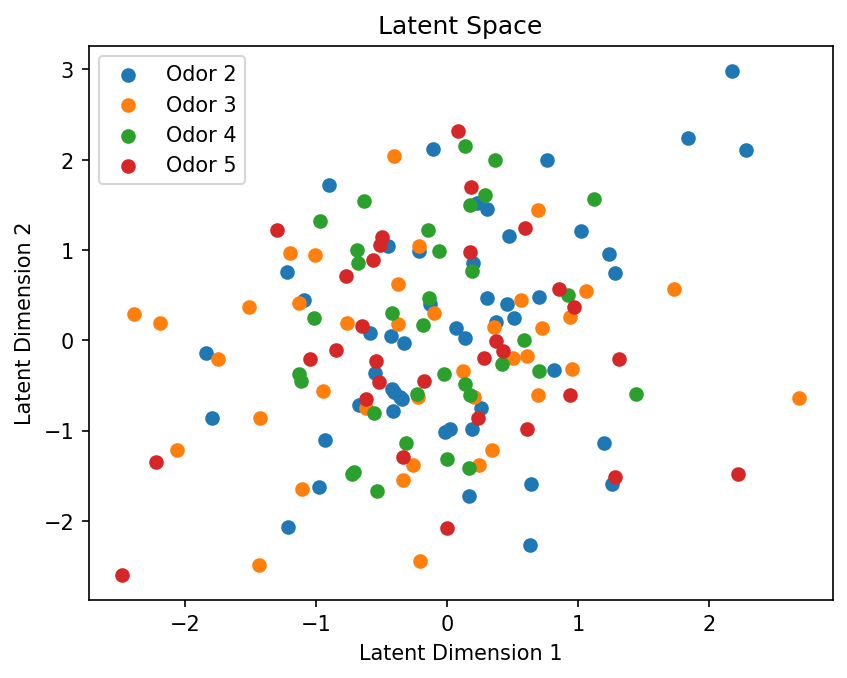

In [150]:
# plot latent space
plt.figure(dpi=150)
unique_odors = np.unique(odor_data_final_np)  # Unique odor labels
for i in unique_odors:
    mask = odor_data_final_np == i  # Mask for points corresponding to odor i
    print(Latent_Space[mask, 0].shape)
    plt.scatter(Latent_Space[mask, 0], Latent_Space[mask, 1], label=f'Odor {int(i)}')

# Add legend and labels
plt.legend()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space")
plt.show()

In [ ]:
num_epochs = 100
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for i, (batch, seq_len) in enumerate(zip(spike_data_batches, spike_lengths)):
        # Prepare batch and move to device
        batch = [batch.to(device)]

        # Forward pass
        reconstructed_batch, mean, logvar, z = model(batch)

        # Ensure batch[0] and reconstructed_batch have the same shape
        if reconstructed_batch.dim() == 3 and reconstructed_batch.size(0) == 1:
            reconstructed_batch = reconstructed_batch.squeeze(0)
        if batch[0].dim() == 2:
            batch[0] = batch[0].unsqueeze(0)

        # Compute lengths tensor and move to device
        lengths = torch.tensor([seq_len], dtype=torch.long).to(device)

        # Compute reconstruction loss with masking
        loss = compute_loss_with_mask(reconstructed_batch, batch[0], mean, logvar, lengths)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for this epoch
        epoch_loss += loss.item()

    # Store average loss for the epoch
    avg_loss = epoch_loss / len(spike_data_batches)
    reconstruction_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

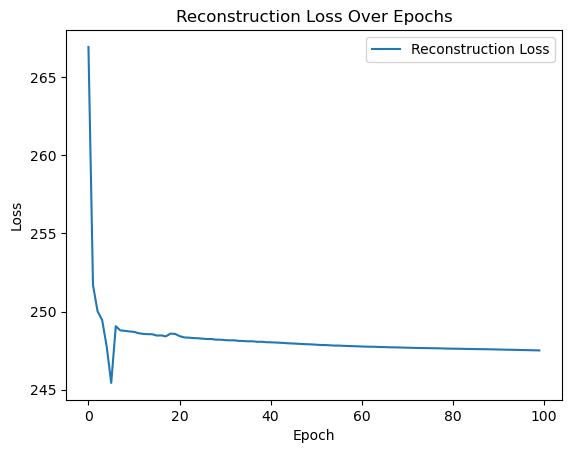

In [72]:
# Plot the losses
plt.figure(dpi=100)
plt.plot(reconstruction_losses, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reconstruction Loss Over Epochs")
plt.legend()
plt.show()